# XGBoost

In [2]:
from Functions import get_result, get_best_threshold, plot_roc_curve, auto_cast, challenge_champion
from xgboost import XGBClassifier
import json
import mlflow
import optuna
import pandas as pd

c:\Users\yann1\miniconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
mlflow.__version__

'3.6.0'

Load the datasets for training (remember they are scaled)

In [ ]:
filenames = ['X_train.pkl', 'Y_train.pkl', 'X_val.pkl', 'Y_val.pkl', 'X_test.pkl', 'Y_test.pkl']
data_folder = '../data/'
dataframes = [pd.read_pickle(data_folder + filename) for filename in filenames]
X_train, Y_train, X_val, Y_val, X_test, Y_test = dataframes

#### Hyperparameter Tuning

In [ ]:
# Read the JSON file
with open('../config.json', 'r') as file:
    config = json.load(file)

# Set the tracking URI for logging using the values from the JSON file
mlflow.set_tracking_uri(uri=f"http://{config['host']}:{config['port']}")

client = mlflow.tracking.MlflowClient()

exp_name = "Credit_Card_Approval"
experiment = mlflow.get_experiment_by_name(exp_name)
exp_id = experiment.experiment_id
exp_id

'1'

In [ ]:
# Set the current active MLflow experiment
mlflow.set_experiment(experiment_id=exp_id)

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1764788131496, experiment_id='1', last_update_time=1764788131496, lifecycle_stage='active', name='Credit_Card_Approval', tags={'mlflow.experimentKind': 'custom_model_development',
 'mlflow.note.content': 'This is the Credit Card Approval project. This '
                        'experiment contains the models for credit card '
                        'approval.',
 'project_name': 'credit-card-approval'}>

In [ ]:
base_run_name = "xgboost"

In [ ]:
prior_runs = mlflow.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.runName LIKE '{base_run_name}%'",
    output_format="pandas",
    max_results=100,
)

print(f"Number of prior runs with base name '{base_run_name}': {len(prior_runs)}")

Number of prior runs with base name 'xgboost': 12


In [ ]:
run_name = f"{base_run_name}_v{int(len(prior_runs))+1}"
run_name

'xgboost_v13'

In [ ]:
# We'll need the count of each class for a hyperparameter
risk_count = Y_train.value_counts()

In [ ]:
def objective(trial):
    with mlflow.start_run(nested=True):
        # Define hyperparameters
        
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),          # Number of trees
            'max_depth': trial.suggest_int('max_depth', 5, 75),                   # Maximum depth of a tree
            'learning_rate': trial.suggest_float('learning_rate', 0.1, 2.5),# Learning rate
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),                        # Fraction of samples to use per tree
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),                 # Fraction of features used per tree
            'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, 100, 250, 500, 1000,    # Control the balance of positive and negative weights (for imbalance)
                                risk_count[0]/risk_count[1]]) # Typical value to consider
        }

        # Initialize the model
        model = XGBClassifier(**params, objective='binary:logistic', eval_metric='aucpr', random_state=42)

        # Train the model
        model.fit(X_train, Y_train)

        # Evaluate the model
        preds = model.predict(X_val)
        metrics = get_result(Y_val, preds)

        # Log the parameters
        mlflow.log_params(params)
        
        # Log the metrics
        mlflow.log_metrics(metrics)

        return metrics['f1']

In [ ]:
artifact_path = "model"
# Initiate the parent run and call the hyperparameter tuning child run logic
with mlflow.start_run(experiment_id=exp_id, run_name=run_name) as parent_run:
    parent_run_id = parent_run.info.run_id
    # Initialize the Optuna study
    study = optuna.create_study(direction='maximize', study_name='XGBoost_Optimization')
    # Execute the hyperparameter optimization trials.
    study.optimize(objective, n_trials=10)

    # Log the best parameters found during the optimization
    mlflow.log_params(study.best_params)

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "Credit Card Approval",
            "optimizer_engine": "optuna",
            "model_family": "XGBClassifier",
            "feature_set_version": 1,
            "version": int(len(prior_runs))+1
        }
    )

    model = XGBClassifier(**study.best_params, objective='binary:logistic', eval_metric='aucpr', random_state=42)
    model.fit(X_train, Y_train)

    # Evaluate the model
    preds = model.predict(X_val)
    metrics = get_result(Y_val, preds)

    # Log the metrics
    mlflow.log_metrics(metrics)

    # Log the final model
    model_info = mlflow.xgboost.log_model(model, 
                             artifact_path=artifact_path,
                             input_example=X_train.iloc[[0]]
                             )
    model_uri = model_info.model_uri

[I 2025-12-19 21:31:28,031] A new study created in memory with name: XGBoost_Optimization
[I 2025-12-19 21:31:50,845] Trial 0 finished with value: 0.0027717166951701363 and parameters: {'n_estimators': 656, 'max_depth': 54, 'learning_rate': 1.2047057660287608, 'subsample': 0.7519549452390313, 'colsample_bytree': 0.8009210100496185, 'scale_pos_weight': 500}. Best is trial 0 with value: 0.0027717166951701363.


🏃 View run stylish-sow-887 at: http://127.0.0.1:8080/#/experiments/1/runs/b7aaca069d0e407cab46337f6a231b81
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 21:31:57,465] Trial 1 finished with value: 0.0028102221831913586 and parameters: {'n_estimators': 131, 'max_depth': 15, 'learning_rate': 2.2543761287103896, 'subsample': 0.734280373681787, 'colsample_bytree': 0.9763245864327148, 'scale_pos_weight': 1000}. Best is trial 1 with value: 0.0028102221831913586.


🏃 View run kindly-cat-848 at: http://127.0.0.1:8080/#/experiments/1/runs/cf8e1f42b92647dd995b14b583c9af5a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 21:32:26,445] Trial 2 finished with value: 0.002853240248899681 and parameters: {'n_estimators': 362, 'max_depth': 67, 'learning_rate': 0.8830845373842497, 'subsample': 0.9777163517135619, 'colsample_bytree': 0.5095484586343993, 'scale_pos_weight': 707.9454545454546}. Best is trial 2 with value: 0.002853240248899681.


🏃 View run magnificent-swan-881 at: http://127.0.0.1:8080/#/experiments/1/runs/93bfd98c54ff40f4a9b625b0966650c3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 21:33:00,045] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 791, 'max_depth': 37, 'learning_rate': 1.6511272664571026, 'subsample': 0.6008510353725933, 'colsample_bytree': 0.6713247202326413, 'scale_pos_weight': 500}. Best is trial 2 with value: 0.002853240248899681.


🏃 View run tasteful-bass-629 at: http://127.0.0.1:8080/#/experiments/1/runs/8213f70de0264e82914345ce43d6961c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 21:33:19,875] Trial 4 finished with value: 0.0028098109231399636 and parameters: {'n_estimators': 563, 'max_depth': 28, 'learning_rate': 1.3514502752043323, 'subsample': 0.8013099484511216, 'colsample_bytree': 0.5134328129393337, 'scale_pos_weight': 500}. Best is trial 2 with value: 0.002853240248899681.


🏃 View run secretive-snipe-232 at: http://127.0.0.1:8080/#/experiments/1/runs/d919ee896ee44a389b3abbc45fbe82a1
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 21:34:34,135] Trial 5 finished with value: 0.008178975222516238 and parameters: {'n_estimators': 626, 'max_depth': 14, 'learning_rate': 0.6046186996224969, 'subsample': 0.505901013897659, 'colsample_bytree': 0.6181797051935907, 'scale_pos_weight': 250}. Best is trial 5 with value: 0.008178975222516238.


🏃 View run unleashed-jay-364 at: http://127.0.0.1:8080/#/experiments/1/runs/3278d0967e8648f8a64d5f4bd3fff297
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 21:34:51,285] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 321, 'max_depth': 69, 'learning_rate': 1.8364583063403104, 'subsample': 0.7216430482040335, 'colsample_bytree': 0.6227578475685731, 'scale_pos_weight': 707.9454545454546}. Best is trial 5 with value: 0.008178975222516238.


🏃 View run entertaining-rook-28 at: http://127.0.0.1:8080/#/experiments/1/runs/1c79d3ebf5fa40628f5e02022324b96f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 21:35:06,405] Trial 7 finished with value: 0.0016602102933038186 and parameters: {'n_estimators': 365, 'max_depth': 71, 'learning_rate': 2.2841661658772594, 'subsample': 0.7182419568214353, 'colsample_bytree': 0.5562342914737655, 'scale_pos_weight': 250}. Best is trial 5 with value: 0.008178975222516238.


🏃 View run grandiose-ray-874 at: http://127.0.0.1:8080/#/experiments/1/runs/40326fe9eae0475aacda6577bea9e5f0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 21:35:26,935] Trial 8 finished with value: 0.002982848620432513 and parameters: {'n_estimators': 529, 'max_depth': 55, 'learning_rate': 2.3640611479573397, 'subsample': 0.9752169160187399, 'colsample_bytree': 0.5495877558812687, 'scale_pos_weight': 250}. Best is trial 5 with value: 0.008178975222516238.


🏃 View run treasured-panda-576 at: http://127.0.0.1:8080/#/experiments/1/runs/8fde1fa1d1c4428cb86f485be31391c0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 21:37:55,345] Trial 9 finished with value: 0.23376623376623376 and parameters: {'n_estimators': 507, 'max_depth': 18, 'learning_rate': 0.5072031790615968, 'subsample': 0.8093948972823235, 'colsample_bytree': 0.8216802559785107, 'scale_pos_weight': 100}. Best is trial 9 with value: 0.23376623376623376.


🏃 View run gregarious-dove-960 at: http://127.0.0.1:8080/#/experiments/1/runs/a99eda194a664cc2b66cf5e22150e42a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


2025/12/19 21:40:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred sche

🏃 View run xgboost_v13 at: http://127.0.0.1:8080/#/experiments/1/runs/8be55e00dc8c480aac757f936a328901
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


In [ ]:
print(f'parent_run_id: {parent_run_id}')
print(f'model_uri: {model_uri}')

parent_run_id: 8be55e00dc8c480aac757f936a328901
model_uri: models:/m-1e4d0fa831284685ba4a37dca858fe10


In [ ]:
model_name = "Credit_Card_Approval_XGBoost"
challenger = mlflow.register_model(
    model_uri = model_uri, 
    name = model_name, 
    tags={
        "project": "Credit Card Approval",
        "model_family": "XGBClassifier"
    }
)

client.set_registered_model_alias(
    name=model_name,
    alias="challenger",
    version=challenger.version
)

Registered model 'Credit_Card_Approval_XGBoost' already exists. Creating a new version of this model...
2025/12/19 21:40:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Credit_Card_Approval_XGBoost, version 12
Created version '12' of model 'Credit_Card_Approval_XGBoost'.


In [ ]:
runs = mlflow.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.parentRunId = '{parent_run_id}'",
    output_format='pandas'
)

In [ ]:
param_cols = [c for c in runs.columns if c.startswith("params.")]

display(runs[[
    'run_id', 
    'metrics.f1', 
    'metrics.recall', 
    'metrics.precision',
    'metrics.accuracy'
    ] + param_cols]
    .sort_values(by='metrics.f1', ascending=False)
    .head(10))

,run_id,metrics.f1,metrics.recall,metrics.precision,metrics.accuracy,params.n_estimators,params.colsample_bytree,params.learning_rate,params.subsample,params.max_depth,params.scale_pos_weight
0,a99eda194a664cc2b66cf5e22150e42a,0.233766,0.375000,0.169811,0.996541,507,0.8216802559785107,0.5072031790615968,0.8093948972823235,18,100
4,3278d0967e8648f8a64d5f4bd3fff297,0.008179,0.354167,0.004137,0.879155,626,0.6181797051935907,0.6046186996224969,0.505901013897659,14,250
1,8fde1fa1d1c4428cb86f485be31391c0,0.002983,0.041667,0.001547,0.960812,529,0.5495877558812687,2.3640611479573397,0.9752169160187399,55,250
7,93bfd98c54ff40f4a9b625b0966650c3,0.002853,0.979167,0.001429,0.037136,362,0.5095484586343993,0.8830845373842497,0.9777163517135619,67,707.9454545454546
8,cf8e1f42b92647dd995b14b583c9af5a,0.002810,1.000000,0.001407,0.001553,131,0.9763245864327148,2.2543761287103896,0.734280373681787,15,1000
5,d919ee896ee44a389b3abbc45fbe82a1,0.002810,1.000000,0.001407,0.001407,563,0.5134328129393337,1.3514502752043323,0.8013099484511216,28,500
9,b7aaca069d0e407cab46337f6a231b81,0.002772,0.979167,0.001388,0.008734,656,0.8009210100496185,1.2047057660287608,0.7519549452390313,54,500
2,40326fe9eae0475aacda6577bea9e5f0,0.001660,0.062500,0.000841,0.894249,365,0.5562342914737655,2.2841661658772594,0.7182419568214353,71,250
3,1c79d3ebf5fa40628f5e02022324b96f,0.000000,0.000000,0.000000,0.998593,321,0.6227578475685731,1.8364583063403104,0.7216430482040335,69,707.9454545454546
6,8213f70de0264e82914345ce43d6961c,0.000000,0.000000,0.000000,0.998593,791,0.6713247202326413,1.6511272664571026,0.6008510353725933,37,500


From the above results we see that all the models with 1.0 scale_pos_weight lays in the lower end compared to the higher ones. Since we have a imbalanced dataset, this make good sense.

Lets take the parameters that resulted in the best performance and test it on our test set and see how well it is doing.

In [ ]:
loaded_model = mlflow.xgboost.load_model(model_uri)

In [ ]:
# Predict on the val set
val_predictions = loaded_model.predict_proba(X_val)[:, 1]

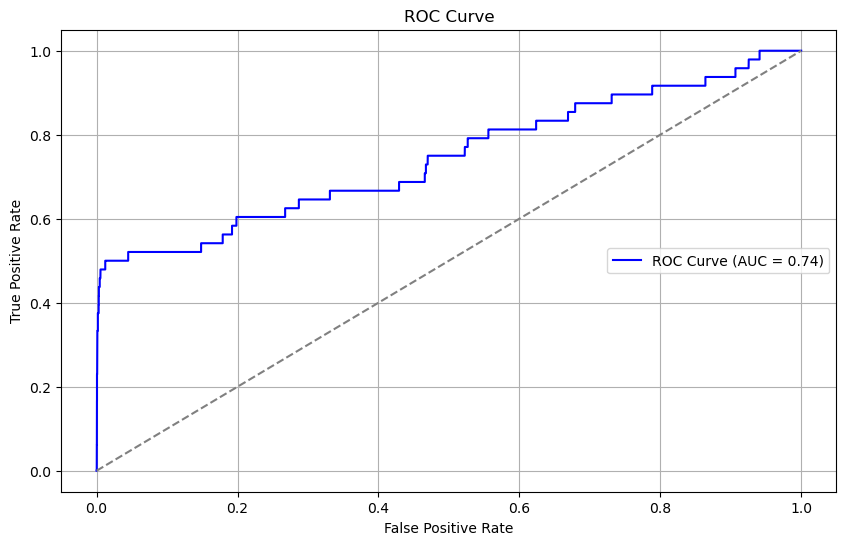

0.7446378778984444

In [ ]:
plot_roc_curve(Y_val, val_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:77: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


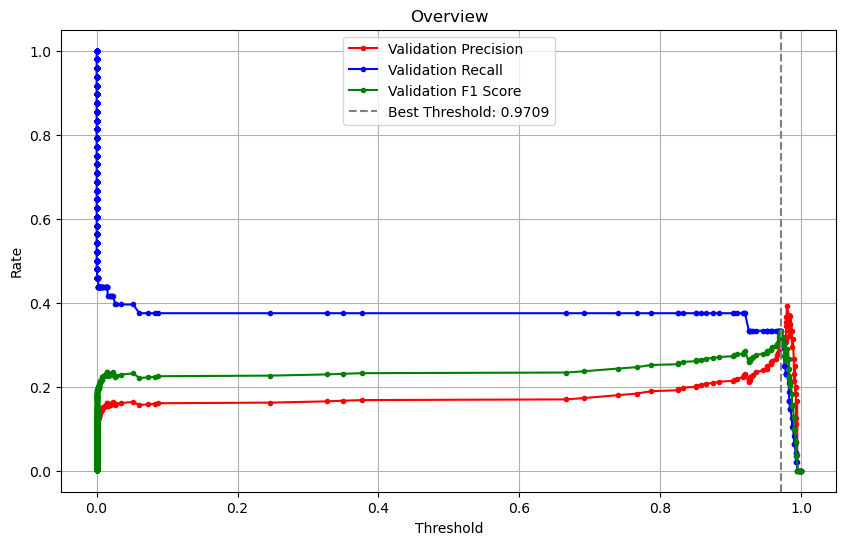

In [ ]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)
client.log_param(parent_run_id, 'best_threshold', best_threshold)
client.set_model_version_tag(
    name=model_name,
    version=challenger.version,
    key="best_threshold",
    value=str(best_threshold)
)

In [ ]:
# Predict on the test set
test_predictions = loaded_model.predict_proba(X_test)[:, 1]

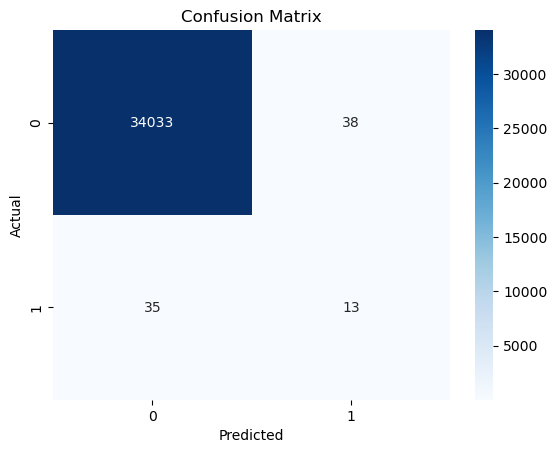

Accuracy     = 1.0
Recall       = 0.27
Precision    = 0.25
F1           = 0.26


In [ ]:
challenger_result = get_result(Y_test, test_predictions, best_threshold, visualize=True)

Lets see if it's better than the current champion model (if this is not the first time running)

-- Confusion matrix for champion model --


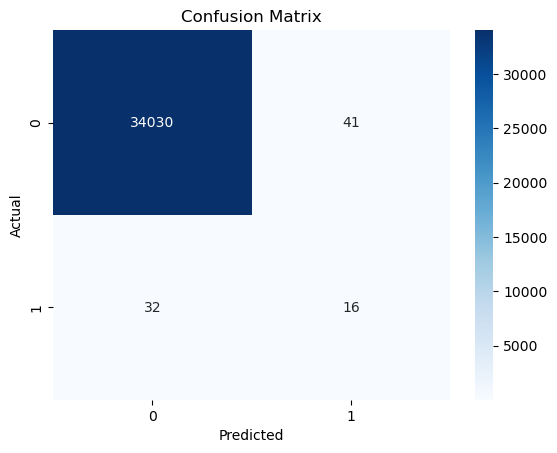

Accuracy     = 1.0
Recall       = 0.33
Precision    = 0.28
F1           = 0.3

- - - - - - - - - - 
Current champion remains


In [ ]:
challenge_champion(
    client, 
    algorithm_name = 'xgboost',
    model_name = model_name, 
    X_test = X_test,
    Y_test = Y_test, 
    challenger_metrics = challenger_result, 
    competing_metric = 'f1'
)

### Train on both training and validation set

Lets merge the training and validation set and predict on the test set to see if the model can perform better with more training data. We'll keep the best threshold, since the model now have seen the data to construct the best threshold. However, I do not think the threshold can get much closer to 1.

In [ ]:
best_run = mlflow.get_run(parent_run_id)
best_params = best_run.data.params
best_params = {k: auto_cast(v) for k, v in best_params.items()}
best_params

{'n_estimators': 507,
 'max_depth': 18,
 'learning_rate': 0.5072031790615968,
 'subsample': 0.8093948972823235,
 'colsample_bytree': 0.8216802559785107,
 'scale_pos_weight': 100,
 'best_threshold': 0.9708604}

In [ ]:
# Initialize the RandomForestClassifier with the best hyperparameters from the tuning phase
xgb = XGBClassifier(**best_params, eval_metric="aucpr", random_state=42)

In [ ]:
# Train the model
xgb.fit(pd.concat([X_train, X_val]), pd.concat([Y_train, Y_val]))

/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:40:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1758008603490/work/src/learner.cc:738: 
Parameters: { "best_threshold" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, best_threshold=0.9708604, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8216802559785107, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5072031790615968,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=507, n_jobs=None, ...)

In [ ]:
# Predict on the val set
val_predictions = xgb.predict_proba(X_val)[:, 1]

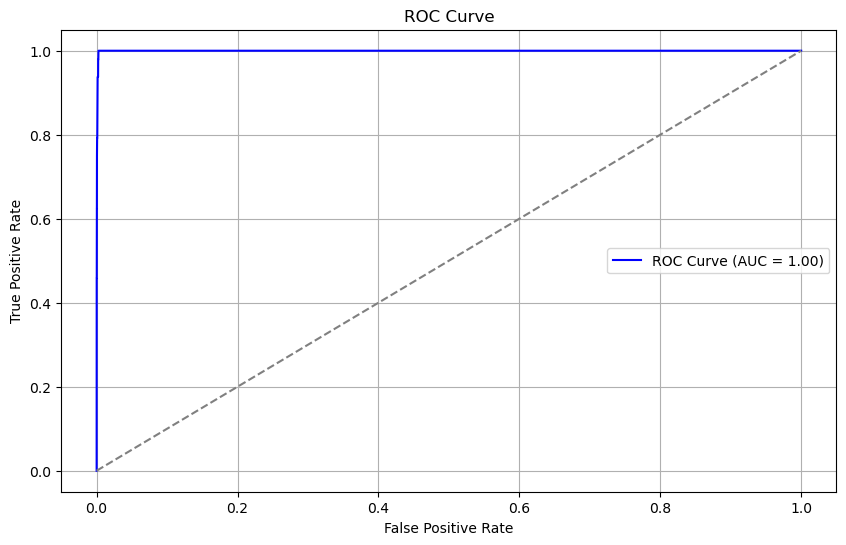

0.9995884698170433

In [ ]:
plot_roc_curve(Y_val, val_predictions)

It does perfect on the ROC Curve, which is not surprising, since the model has been trained on the data

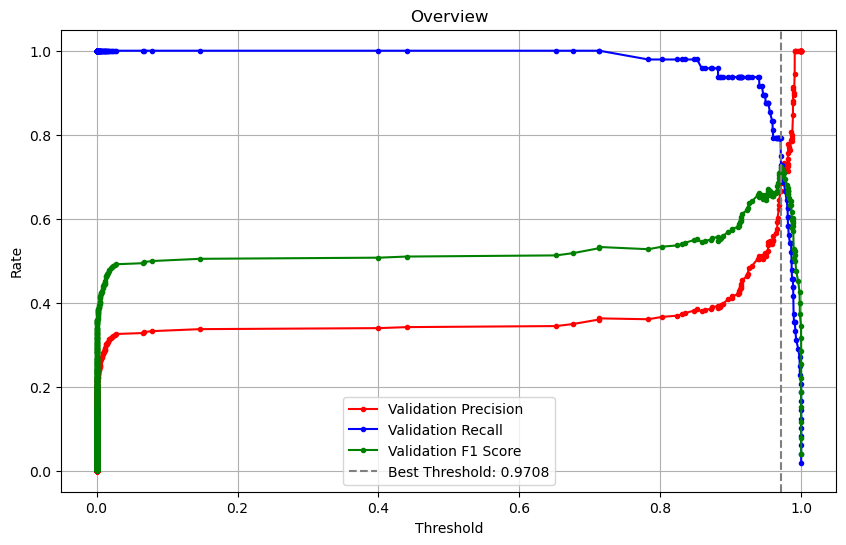

In [ ]:
_ = get_best_threshold('Validation', Y_val, val_predictions)

In [ ]:
# Predict on the test set
test_predictions = xgb.predict_proba(X_test)[:, 1]

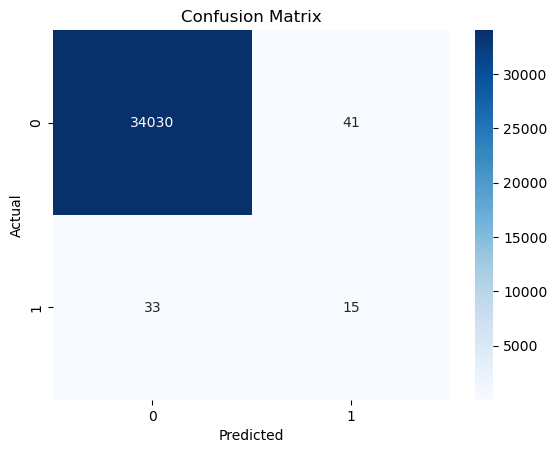

Accuracy     = 1.0
Recall       = 0.31
Precision    = 0.27
F1           = 0.29


In [ ]:
result_2 = get_result(Y_test, test_predictions, best_threshold, visualize=True)

In [ ]:
if result_2['f1'] > challenger_result['f1']:
    print('By training our model on more data, we achived a higher performance on the F1 score')
else:
    print('The first model we found, through hyperparameter tuning, is still our best model on the F1 score.')
    print('It had the following scores:')
    print('Recall       =', round(challenger_result['recall'], 2))
    print('Precision    =', round(challenger_result['precision'], 2))
    print('F1           =', round(challenger_result['f1'], 2))

By training our model on more data, we achived a higher performance on the F1 score
